In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from generation.dataset.dataset import get_detector_event_df, get_detector_event_signal, get_detector_event_df_path

In [2]:
_DETECTORS_NUM = 9
_EVENTS_NUM = 200


def get_event_amplitudes(event):
    detector_signals = [get_detector_event_signal(detector, event) for detector in range(_DETECTORS_NUM)]
    amplitudes = np.array([np.max(signal) for signal in detector_signals])
    return amplitudes

event_amplitudes = np.array([get_event_amplitudes(event) for event in range(_EVENTS_NUM)])

In [3]:
correlations = np.zeros((_DETECTORS_NUM, _DETECTORS_NUM))

for detector1 in tqdm.tqdm(range(_DETECTORS_NUM)):
    for detector2 in range(_DETECTORS_NUM):
        amplitudes1 = event_amplitudes[:, detector1]
        amplitudes2 = event_amplitudes[:, detector2]
        corrcoef = np.corrcoef(amplitudes1, amplitudes2)[0][1]
        correlations[detector1][detector2] = round(corrcoef, 2)
        
print(correlations)

100%|██████████| 9/9 [00:00<00:00, 736.03it/s]

[[1.   0.19 0.09 0.35 0.27 0.13 0.29 0.14 0.15]
 [0.19 1.   0.27 0.32 0.44 0.17 0.12 0.25 0.19]
 [0.09 0.27 1.   0.1  0.35 0.17 0.03 0.16 0.27]
 [0.35 0.32 0.1  1.   0.35 0.13 0.2  0.16 0.05]
 [0.27 0.44 0.35 0.35 1.   0.43 0.21 0.45 0.33]
 [0.13 0.17 0.17 0.13 0.43 1.   0.07 0.15 0.38]
 [0.29 0.12 0.03 0.2  0.21 0.07 1.   0.16 0.13]
 [0.14 0.25 0.16 0.16 0.45 0.15 0.16 1.   0.19]
 [0.15 0.19 0.27 0.05 0.33 0.38 0.13 0.19 1.  ]]


100%|██████████| 9/9 [00:00<00:00, 20.97it/s]


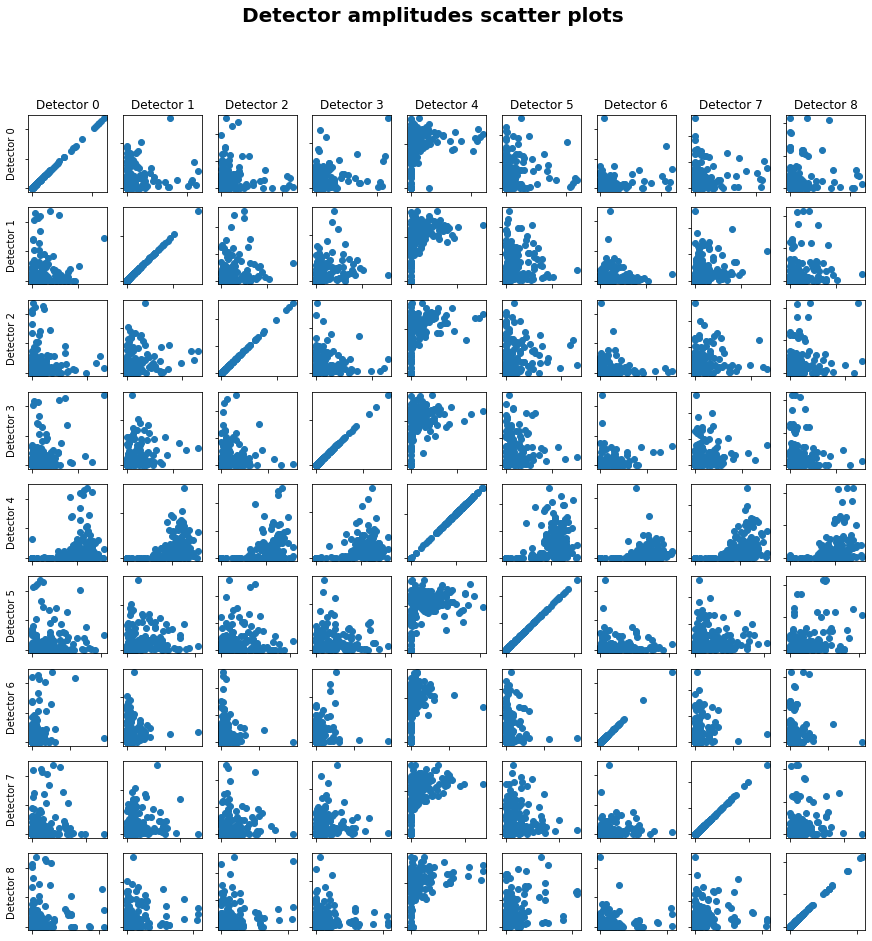

In [5]:
def plot_scatter(ax, detector1, detector2):
    amplitudes1 = event_amplitudes[:, detector1]
    amplitudes2 = event_amplitudes[:, detector2]
    ax.scatter(amplitudes1, amplitudes2)

f, ax = plt.subplots(_DETECTORS_NUM, _DETECTORS_NUM, figsize=(15, 15))
cols = ['Detector {}'.format(detector) for detector in range(_DETECTORS_NUM)]
rows = ['Detector {}'.format(detector) for detector in range(_DETECTORS_NUM)]

for _ax, col in zip(ax[0], cols):
    _ax.set_title(col)
for _ax, row in zip(ax[:,0], rows):
    _ax.set_ylabel(row, rotation=90)

f.suptitle("Detector amplitudes scatter plots", fontsize=20, weight='bold')
for detector1 in tqdm.tqdm(range(_DETECTORS_NUM)):
    for detector2 in range(_DETECTORS_NUM):
        ax[detector1][detector2].set_xticklabels([])
        ax[detector1][detector2].set_yticklabels([])
        plot_scatter(ax[detector1][detector2], detector1, detector2)
plt.show()

### WGAN

In [6]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from generation.dataset.dataset_pytorch import SignalsDataset
from generation.train.wgan import run_train, generate_new_signal

In [7]:
SAMPLE_SIZE = 9

# Train params
NUM_EPOCHS = 100000
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
LATENT_DIM = 8 
PRINT_EACH = 250
VERBOSE = 1
NO_SAVE = True

In [8]:
origin_data = np.array([get_event_amplitudes(event) for event in range(_EVENTS_NUM)])
min_values = np.min(origin_data, axis=0)
max_values = np.max(origin_data, axis=0)
data = (origin_data  - min_values) / (max_values - min_values)
dataset = SignalsDataset(data)

In [9]:
generator = run_train(dataset, \
          latent_dim=LATENT_DIM, \
          sample_size=SAMPLE_SIZE, \
          learning_rate=LEARNING_RATE, \
          num_epochs=NUM_EPOCHS, \
          batch_size=BATCH_SIZE, \
          print_each=PRINT_EACH, \
          verbose=VERBOSE, \
          no_save=NO_SAVE)

epoch-0; D_loss: 0.00017663650214672089; G_loss: 0.009456477127969265
epoch-250; D_loss: -0.006140212528407574; G_loss: 0.017558977007865906
epoch-500; D_loss: -0.0033694030717015266; G_loss: 0.015667051076889038
epoch-750; D_loss: -0.0007538069039583206; G_loss: 0.013613798655569553
epoch-1000; D_loss: -0.00015702657401561737; G_loss: 0.01295444741845131
epoch-1250; D_loss: -0.00047576799988746643; G_loss: 0.011515083722770214
epoch-1500; D_loss: -0.0003096163272857666; G_loss: 0.011805856600403786
epoch-1750; D_loss: -0.00027589406818151474; G_loss: 0.011093695648014545
epoch-2000; D_loss: -0.00012614857405424118; G_loss: 0.010899893008172512
epoch-2250; D_loss: -0.00021549686789512634; G_loss: 0.010999276302754879
epoch-2500; D_loss: -0.00023027602583169937; G_loss: 0.01107740867882967
epoch-2750; D_loss: -0.0001638336107134819; G_loss: 0.008743558079004288
epoch-3000; D_loss: -0.00036389660090208054; G_loss: 0.009878173470497131
epoch-3250; D_loss: -0.0001560719683766365; G_loss: 0

epoch-28000; D_loss: -4.9192458391189575e-05; G_loss: 0.010099805891513824
epoch-28250; D_loss: -8.567329496145248e-05; G_loss: 0.01011184137314558
epoch-28500; D_loss: 1.0662712156772614e-05; G_loss: 0.010179201140999794
epoch-28750; D_loss: -2.2353604435920715e-05; G_loss: 0.010160036385059357
epoch-29000; D_loss: 7.243826985359192e-06; G_loss: 0.010053289122879505
epoch-29250; D_loss: -4.9266964197158813e-05; G_loss: 0.010115709155797958
epoch-29500; D_loss: -3.4623779356479645e-05; G_loss: 0.010066249407827854
epoch-29750; D_loss: -4.3888576328754425e-05; G_loss: 0.010038764216005802
epoch-30000; D_loss: 4.602130502462387e-05; G_loss: 0.010017987340688705
epoch-30250; D_loss: -4.005804657936096e-05; G_loss: 0.010018900036811829
epoch-30500; D_loss: -5.369260907173157e-05; G_loss: 0.010075762867927551
epoch-30750; D_loss: -3.0036084353923798e-05; G_loss: 0.010051862336695194
epoch-31000; D_loss: -8.886680006980896e-06; G_loss: 0.009766959585249424
epoch-31250; D_loss: -6.57681375741

epoch-55750; D_loss: -2.7027912437915802e-05; G_loss: 0.009899469092488289
epoch-56000; D_loss: 1.3285316526889801e-05; G_loss: 0.009889448061585426
epoch-56250; D_loss: -2.5294721126556396e-05; G_loss: 0.009787088260054588
epoch-56500; D_loss: -3.07280570268631e-05; G_loss: 0.009479232132434845
epoch-56750; D_loss: -1.229066401720047e-05; G_loss: 0.010105411522090435
epoch-57000; D_loss: -9.384565055370331e-05; G_loss: 0.009663483127951622
epoch-57250; D_loss: -5.076266825199127e-05; G_loss: 0.010017282329499722
epoch-57500; D_loss: -0.00010296236723661423; G_loss: 0.00986448209732771
epoch-57750; D_loss: -6.223376840353012e-05; G_loss: 0.009837755933403969
epoch-58000; D_loss: -4.1153281927108765e-05; G_loss: 0.009799398481845856
epoch-58250; D_loss: -3.7697143852710724e-05; G_loss: 0.00989745743572712
epoch-58500; D_loss: -1.2877397239208221e-05; G_loss: 0.009627167135477066
epoch-58750; D_loss: -5.371216684579849e-05; G_loss: 0.009924349375069141
epoch-59000; D_loss: -1.21779739856

epoch-83500; D_loss: -4.4889748096466064e-07; G_loss: 0.009905947372317314
epoch-83750; D_loss: -3.637745976448059e-06; G_loss: 0.016738640144467354
epoch-84000; D_loss: -5.23887574672699e-05; G_loss: 0.012878349050879478
epoch-84250; D_loss: 1.450907438993454e-05; G_loss: 0.010392735712230206
epoch-84500; D_loss: -9.055808186531067e-05; G_loss: 0.009892103262245655
epoch-84750; D_loss: -0.00014808308333158493; G_loss: 0.01020729262381792
epoch-85000; D_loss: 2.8213486075401306e-05; G_loss: 0.010509795509278774
epoch-85250; D_loss: -4.735030233860016e-05; G_loss: 0.010238689370453358
epoch-85500; D_loss: -0.00015549082309007645; G_loss: 0.009626541286706924
epoch-85750; D_loss: -5.359668284654617e-05; G_loss: 0.010364437475800514
epoch-86000; D_loss: -2.1938234567642212e-05; G_loss: 0.01086188480257988
epoch-86250; D_loss: 1.994706690311432e-05; G_loss: 0.010173289105296135
epoch-86500; D_loss: -7.371604442596436e-05; G_loss: 0.010175544768571854
epoch-86750; D_loss: -3.444030880928039

In [10]:
generated_signals = np.array([generate_new_signal(generator)[0] for i in range(len(origin_data))])

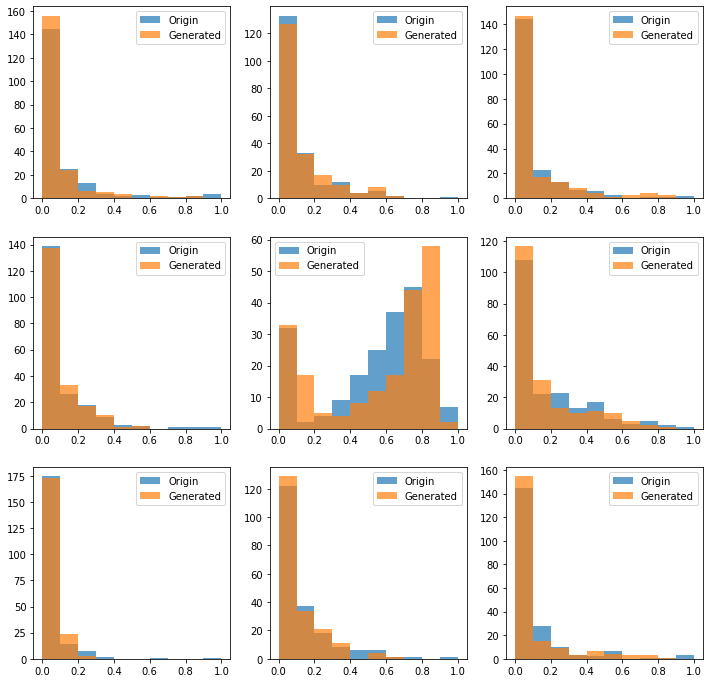

In [11]:
f, ax = plt.subplots(3, 3, figsize=(12, 12))
_bins = np.arange(0, 1.1, 0.1)
for detector in range(9):
    gen = generated_signals[:, detector]
    ori = data[:, detector]
    ax[detector//3][detector % 3].hist(ori, alpha=0.7, bins=_bins)
    ax[detector//3][detector % 3].hist(gen, alpha=0.7, bins=_bins)
    ax[detector//3][detector % 3].legend(['Origin', 'Generated'])